### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from wordcloud import WordCloud
import numpy as np
import nltk
nltk.download('punkt')
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import os;
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
import bz2
import transformers
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig,RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
from transformers import InputExample, InputFeatures
import logging
transformers.logging.set_verbosity_error()
from sklearn.model_selection import train_test_split #"train_test_split" function in scikit-learn is used to split a dataset into training and testing subsets.
from sklearn.preprocessing import StandardScaler #"StandardScaler" class in scikit-learn is used for standardizing numericalfeatures in a dataset.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load Dataset

In [3]:
def labels_texts(file):
    linesRead = 0
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        if(linesRead==25000):
            break
        x = line.decode("utf-8")
        labels.append(x[:10])
        texts.append(x[10:].strip())
        linesRead+=1
    return np.array(labels), texts

In [4]:
#https://www.kaggle.com/code/akshitkarande/amazon-reviews-for-sentiment-analysis/input
train_label, train_text = labels_texts("/content/drive/MyDrive/train.ft.txt.bz2")
test_label, test_text = labels_texts("/content/drive/MyDrive/test.ft.txt.bz2")

In [5]:
amazon_review_df = pd.DataFrame(train_text,columns=['Reviews'])
amazon_review_df['Label'] = train_label.tolist()

#__label__1->negative(i.e 0)

amazon_review_df.loc[amazon_review_df['Label']=='__label__2','Sentiment'] = 1

#__label__2->positive(i.e 1)
amazon_review_df.loc[amazon_review_df['Label']=='__label__1','Sentiment'] = 0
amazon_review_df['Sentiment'] = amazon_review_df['Sentiment'].astype(int)

In [6]:
amazon_review_test = pd.DataFrame(test_text,columns=['Reviews'])
amazon_review_test['Label'] = test_label.tolist()

#__label__1->negative(i.e 0)

amazon_review_test.loc[amazon_review_test['Label']=='__label__2','Sentiment'] = 1

#__label__2->positive(i.e 1)
amazon_review_test.loc[amazon_review_test['Label']=='__label__1','Sentiment'] = 0
amazon_review_test['Sentiment'] = amazon_review_test['Sentiment'].astype(int)

In [ ]:

print((amazon_review_df['Sentiment']==0).sum())
print((amazon_review_df['Sentiment']==1).sum())

12117
12883


In [ ]:
amazon_review_df.head()

,Reviews,Label,Sentiment
0,Stuning even for the non-gamer: This sound tra...,__label__2,1
1,The best soundtrack ever to anything.: I'm rea...,__label__2,1
2,Amazing!: This soundtrack is my favorite music...,__label__2,1
3,Excellent Soundtrack: I truly like this soundt...,__label__2,1
4,"Remember, Pull Your Jaw Off The Floor After He...",__label__2,1


### Preprocessing and Clean Data

In [7]:
stp_words=stopwords.words('english')

def clean_review(review):
    cleanreview =" ".join(word for word in review.
                       split() if word.lower() not in stp_words)
    return cleanreview



In [8]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result



In [9]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output



In [10]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)



In [11]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [12]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [13]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final



In [14]:
amazon_review_df['Reviews']=amazon_review_df['Reviews'].apply(clean_review)
amazon_review_df['Reviews']=amazon_review_df['Reviews'].apply(clean)
amazon_review_df['Reviews']=amazon_review_df['Reviews'].apply(deEmojify)
amazon_review_df['Reviews']=amazon_review_df['Reviews'].apply(unify_whitespaces)
amazon_review_df['Reviews']=amazon_review_df['Reviews'].apply(remove_symbols)
amazon_review_df['Reviews']=amazon_review_df['Reviews'].apply(remove_punctuation)


In [15]:
amazon_review_test['Reviews']=amazon_review_test['Reviews'].apply(clean_review)
amazon_review_test['Reviews']=amazon_review_test['Reviews'].apply(clean)
amazon_review_test['Reviews']=amazon_review_test['Reviews'].apply(deEmojify)
amazon_review_test['Reviews']=amazon_review_test['Reviews'].apply(unify_whitespaces)
amazon_review_test['Reviews']=amazon_review_test['Reviews'].apply(remove_symbols)
amazon_review_test['Reviews']=amazon_review_test['Reviews'].apply(remove_punctuation)

In [147]:
amazon_review_df.head()

,Reviews,Label,Sentiment
0,Stuning even non gamer sound track beautiful p...,__label__2,1
1,best soundtrack ever anything I m reading lot ...,__label__2,1
2,Amazing soundtrack favorite music time hands d...,__label__2,1
3,Excellent Soundtrack truly like soundtrack enj...,__label__2,1
4,Remember Pull Jaw Floor Hearing it played game...,__label__2,1


### Exploratory Data Analysis

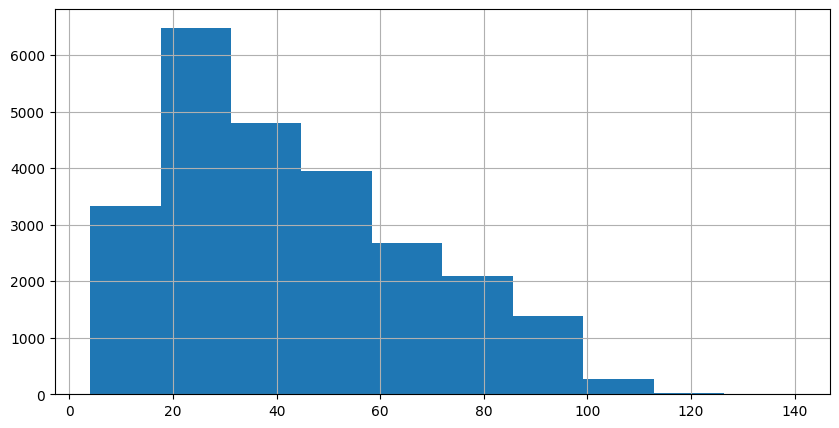

,0
count,25000.00000
mean,43.21076
std,23.70807
min,4.00000
25%,23.00000
50%,38.00000
75%,59.00000
max,140.00000


In [146]:
reviews_len = [len(x.split()) for x in amazon_review_df['Reviews']]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

Sentiment
0    12117
1    12883
dtype: int64


<Axes: >

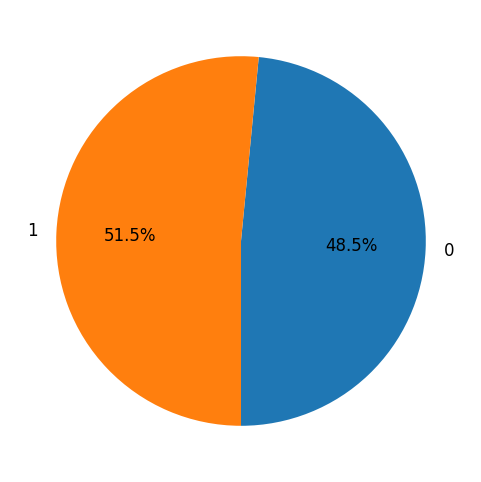

In [148]:
sentiment_counts = amazon_review_df.groupby(['Sentiment']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [149]:
fig = px.histogram(amazon_review_df, x="Sentiment")
fig.update_traces(marker_color="green",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()

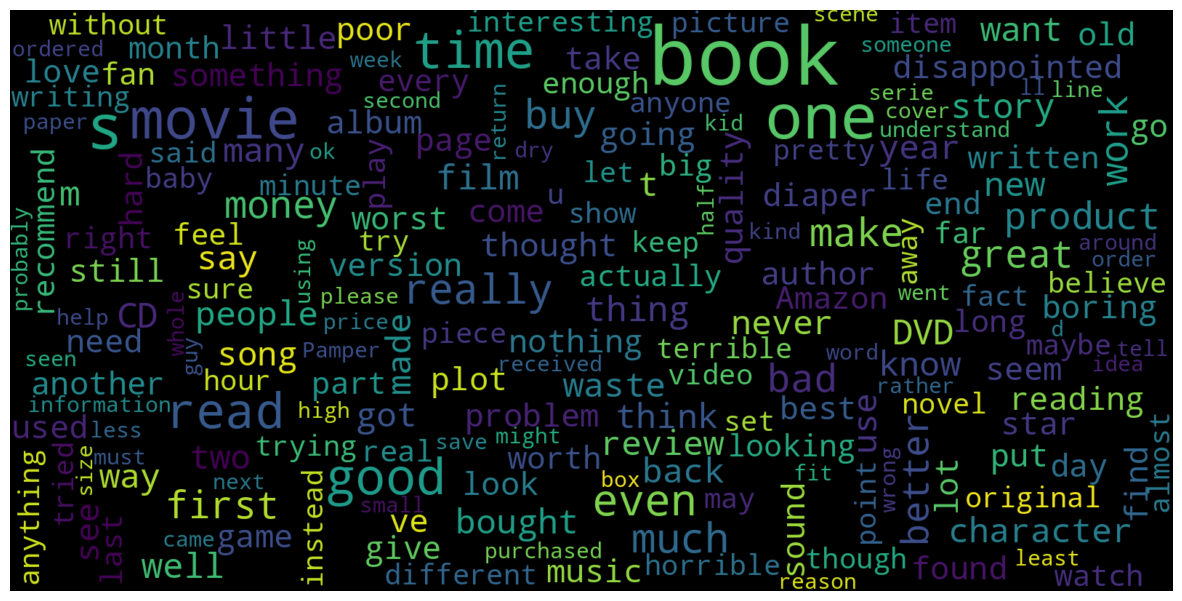

In [150]:
words=' '.join(word for word in amazon_review_df['Reviews'][amazon_review_df['Sentiment']==0].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=42,max_font_size=110,collocations=False)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(words),interpolation='bilinear')
plt.axis('off')
plt.show()

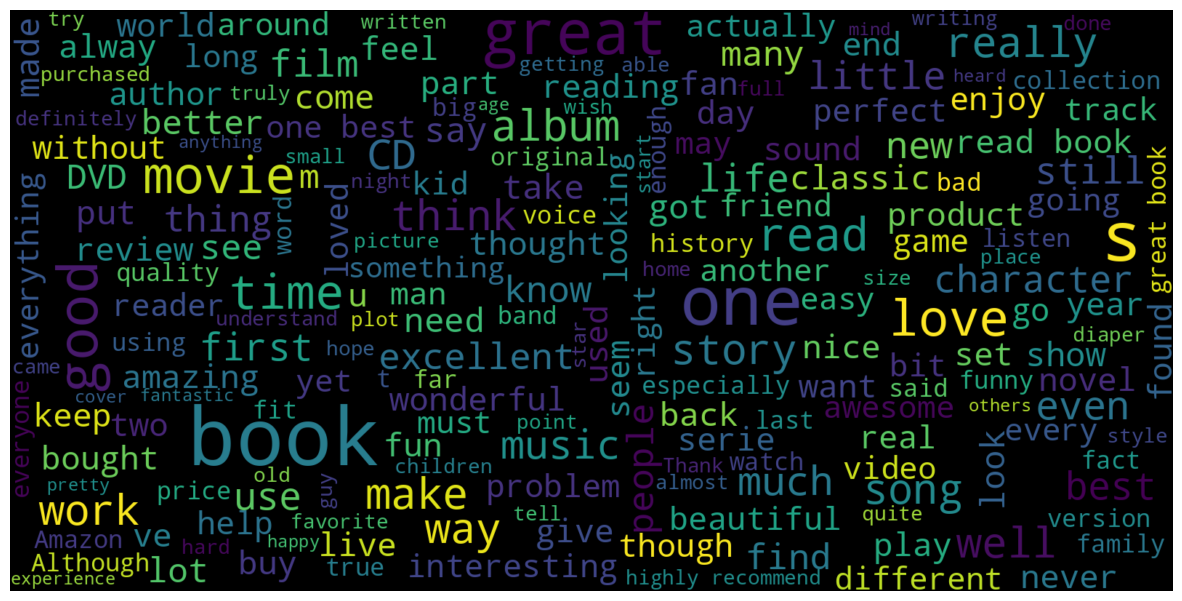

In [151]:
consolidated=' '.join(word for word in amazon_review_df['Reviews'][amazon_review_df['Sentiment']==1].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) #tf.strings is a module in the TensorFlow library that provides a collection of operations for working with strings in TensorFlow.
    return tf.strings.regex_replace(lowercase, '[^a-zA-Z0-9]', ' ') # replace any character that is not a letter or a digit with a space character

def custom_splitting(input_data):
    return tf.strings.split(input_data)

### BERT

### split on train set (20% for validation)

In [17]:
train_reviews =  amazon_review_df['Reviews'].values.tolist()
train_labels = amazon_review_df['Sentiment'].tolist()
test_reviews =  amazon_review_test['Reviews'].values.tolist()
test_labels = amazon_review_test['Sentiment'].tolist()

In [18]:
train_texts_Bert, val_texts_Bert, train_labels_Bert, val_labels_Bert = train_test_split(
    train_reviews, train_labels, test_size=0.2, random_state=42, shuffle=True )

### Assign tokenizer object to the tokenizer class

In [19]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
print(len(train_texts_Bert), len(val_texts_Bert), len(test_text))


8000 2000 10000


In [20]:
train_encodings = tokenizer(train_texts_Bert, truncation=True, padding=True, return_tensors="tf")
val_encodings = tokenizer(val_texts_Bert, truncation=True, padding=True, return_tensors="tf")
test_encodings = tokenizer(test_reviews, truncation=True, padding=True, return_tensors="tf")

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels_Bert
))


In [22]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels_Bert
))

In [23]:
val_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(val_encodings),
                            val_labels_Bert
                            ))

In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(test_encodings),
                            test_labels
                            ))

In [ ]:
train_texts_Bert[0]

'study spiritual ecstacy seeking ultimate jazz experience album Man seeks meaning finding beautiful aesthetic Coletrane helped us find moment think moment recorded Love Supreme stands right border beauty chaos many later avant garde works even later works Coletrane run past border become difficult listen to Love Supreme remains realm listener allowed enter experience artist Love Supreme ultimate jazz album CLASSIC'

In [ ]:
print(tokenizer.batch_decode(train_encodings["input_ids"][0]))

['[ C L S ]', 'i t', 'd i s a p p o i n t e d', 'b o o k', 's l o w', 'r e a d', 's p e n d', 'r e a d i n g', 'a w a i t i n g', 's o m e t h i n g', 'o c c u r', 'b o r e d', 'm a j o r i t y', 'b o o k', 'r e a d e r', 'a t t e m p t s', 'f i n i s h', 's t a r t', 'r e a d i n g', 'b o o k', 's i n c e', 'd e c e m b e r', '2 3', '2 0 0 6', 'n o w', 'm a r c h', '2 0 0 7', 'p u r c h a s e', 'b o o k', 'b u y', 'u s e d', 'b e t t e r', 'y e t', 'm i n e', '[ S E P ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[

In [ ]:
print(train_encodings["input_ids"][0])

tf.Tensor(
[  101  2009  9364  2338  4030  3191  5247  3752 15497  2242  5258 11471
  3484  2338  8068  4740  3926  2707  3752  2338  2144  2285  2603  2294
  2085  2233  2289  5309  2338  4965  2109  2488  2664  3067   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [ ]:
print(train_encodings["attention_mask"][0])

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(273,), dtype=int32)


In [43]:
config = RobertaConfig.from_pretrained(
    'roberta-base',
    num_labels=2
)
 # For binary sentiment analysis

In [44]:
bert_model = TFRobertaForSequenceClassification.from_pretrained(
    'roberta-base', config=config
)

In [45]:
for i, layer in enumerate(bert_model.roberta.encoder.layer):
    if i < 7 :  # Freeze the first 6 layers
        layer.trainable = False
    else:
        layer.trainable = True

# Check which layers are trainable
for i, layer in enumerate(bert_model.roberta.encoder.layer):
    print(f"Layer {i} trainable: {layer.trainable}")

Layer 0 trainable: False
Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: True
Layer 8 trainable: True
Layer 9 trainable: True
Layer 10 trainable: True
Layer 11 trainable: True


In [46]:
l1 = tf.keras.regularizers.L1(0.5)

# Apply L1 regularization to the dense layers in the model
for layer in bert_model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = l1

In [47]:
# Add L2 regularization and Dropout to the model
for layer in bert_model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = l2(0.5)
        layer.dropout = Dropout(0.6)

In [ ]:
print(bert_model.summary())

Model: "tf_distil_bert_for_sequence_classification_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_194 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 592130 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
None


In [48]:
optimizer = AdamW(
    learning_rate=2e-6,
    epsilon=1e-08,
  weight_decay=0.4
)
loss_function = tf.keras.losses.BinaryCrossentropy()
accuracy_metric = tf.keras.metrics.BinaryAccuracy()
bert_model.compile(
    loss=bert_model.hf_compute_loss,
    optimizer=optimizer,
    metrics=['accuracy']  # Use binary accuracy for binary classification
)



In [49]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Stop if no improvement for 3 epochs
    verbose=1,  # Print messages during training
    mode='min',  # Minimize the validation loss
    restore_best_weights=True  # Restore model weights from the best epoch
)

In [50]:

# Train the model with checkpointing
hist = bert_model.fit(
    train_dataset.shuffle(100).batch(16),
    epochs=6,
    batch_size=16,
    callbacks=[early_stopping],  # Apply early stopping
    validation_data=val_dataset.shuffle(100).batch(16)
)
# Save the entire model after training in the TensorFlow native format
model_path = "/content/drive/MyDrive/bert_model"  # No .h5 extension
bert_model.save(model_path, save_format='tf')


Epoch 1/6
1250/1250 [==============================] - 440s 333ms/step - loss: 0.4075 - accuracy: 0.8009 - val_loss: 0.2741 - val_accuracy: 0.8890
Epoch 2/6
1250/1250 [==============================] - 409s 327ms/step - loss: 0.2861 - accuracy: 0.8831 - val_loss: 0.2549 - val_accuracy: 0.8990
Epoch 3/6
1250/1250 [==============================] - 409s 327ms/step - loss: 0.2646 - accuracy: 0.8915 - val_loss: 0.2471 - val_accuracy: 0.9030
Epoch 4/6
1250/1250 [==============================] - 409s 327ms/step - loss: 0.2535 - accuracy: 0.8961 - val_loss: 0.2399 - val_accuracy: 0.9060
Epoch 5/6
1250/1250 [==============================] - 408s 327ms/step - loss: 0.2397 - accuracy: 0.9030 - val_loss: 0.2393 - val_accuracy: 0.9086
Epoch 6/6
1250/1250 [==============================] - 408s 327ms/step - loss: 0.2294 - accuracy: 0.9087 - val_loss: 0.2353 - val_accuracy: 0.9088
Restoring model weights from the end of the best epoch: 6.


In [51]:

loss, accuracy = bert_model.evaluate(test_dataset.batch(16))

print("The accuracy is " + str(accuracy))
print("The loss is " + str(loss))

1563/1563 [==============================] - 213s 134ms/step - loss: 0.2504 - accuracy: 0.9036
The accuracy is 0.9036399722099304
The loss is 0.25036266446113586


In [52]:
input_strings = ["I absolutely love this product!", "I hate this item. It is terrible!","The product arrived late"]

for input_string in input_strings:
    # Tokenize the input string
    inputs = tokenizer(input_string, return_tensors="tf", truncation=True, padding=True, max_length=128)

    # Make prediction
    outputs = bert_model(inputs)
    predictions = tf.nn.softmax(outputs.logits, axis=-1)

    # Get the predicted label
    predicted_label = tf.argmax(predictions, axis=1).numpy()[0]

    # Map label to sentiment
    sentiments = ["Negative", "Positive"]
    sentiment = sentiments[predicted_label]

    print(f"Review: {input_string}")
    print(f"Sentiment: {sentiment}\n")

Review: I absolutely love this product!
Sentiment: Positive

Review: I hate this item. It is terrible!
Sentiment: Negative

Review: The product arrived late
Sentiment: Negative



### Accuracy and Loss Curves

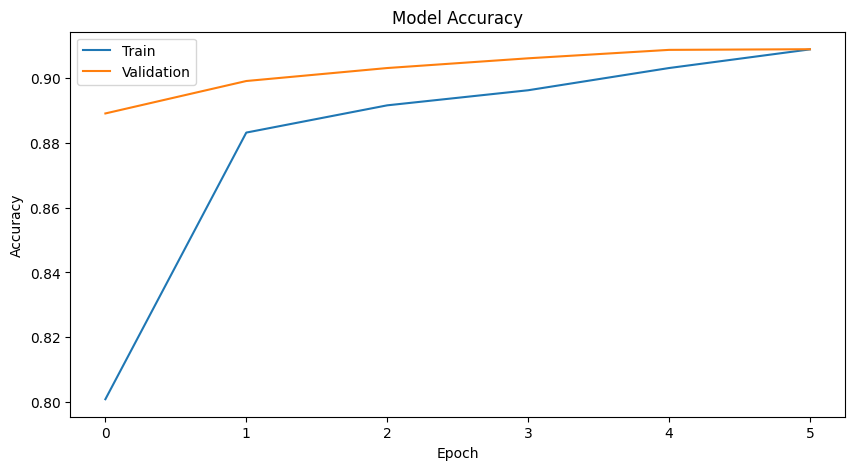

In [53]:
# Plot the training and validation accuracy over epochs
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

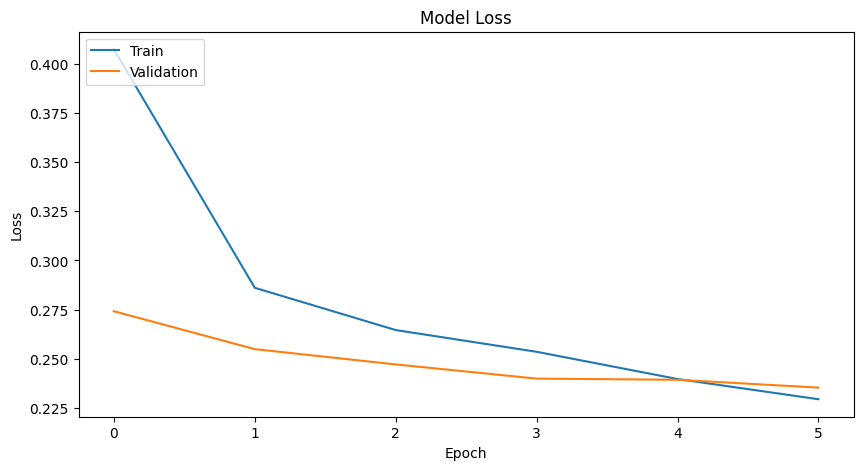

In [54]:
# Plot the training and validation loss over epochs
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### LSTM Model

In [59]:
X = amazon_review_df['Reviews']
y = amazon_review_df['Sentiment']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True)

In [61]:
max_len = 150
vectorizer = TextVectorization(
    max_tokens=1000,
    output_mode='int',
    output_sequence_length=max_len,
    standardize=custom_standardization,
    split=custom_splitting
)

vectorizer.adapt(X_train)
X_train_l = vectorizer(X_train)
X_train_l = pad_sequences(X_train_l,maxlen=max_len)
X_test_l = vectorizer(X_test)
X_test_l = pad_sequences(X_test_l,maxlen=max_len)

In [125]:
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=256))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop if no improvement for 3 epochs
    verbose=1,  # Print status messages during training
    mode='min',  # We want to minimize the validation loss
    restore_best_weights=True  # Restore model to best weights if stopping early
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
accuracy = tf.keras.metrics.BinaryAccuracy()
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),  # Use binary cross-entropy for binary classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adam optimizer with a reasonable learning rate
    metrics=['accuracy']  # Metric to measure accuracy
)
model.summary()

batch_size = 16
epochs = 5

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_47 (Bidirect  (None, None, 64)          73984     
 ional)                                                          
                                                                 
 dropout_94 (Dropout)        (None, None, 64)          0         
                                                                 
 global_max_pooling1d_47 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_94 (Dense)            (None, 16)                1040      
                                                                 
 dropout_95 (Dropout)        (None, 16)              

In [126]:
history = model.fit(X_train_l, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_l,y_test), callbacks=[early_stopping,lr_scheduler],shuffle=True)

Epoch 1/5
1250/1250 [==============================] - 33s 23ms/step - loss: 0.5878 - accuracy: 0.6959 - val_loss: 0.4856 - val_accuracy: 0.8304 - lr: 1.0000e-04
Epoch 2/5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4148 - accuracy: 0.8273 - val_loss: 0.4317 - val_accuracy: 0.8460 - lr: 1.0000e-04
Epoch 3/5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3773 - accuracy: 0.8445 - val_loss: 0.4144 - val_accuracy: 0.8464 - lr: 1.0000e-04
Epoch 4/5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3563 - accuracy: 0.8562 - val_loss: 0.3978 - val_accuracy: 0.8498 - lr: 1.0000e-04
Epoch 5/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3452 - accuracy: 0.8607 - val_loss: 0.3930 - val_accuracy: 0.8506 - lr: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


In [130]:
model_path = "/content/drive/MyDrive/blstm_model"  # No .h5 extension
model.save(model_path, save_format='tf')

### Accuracy and Loss Curves

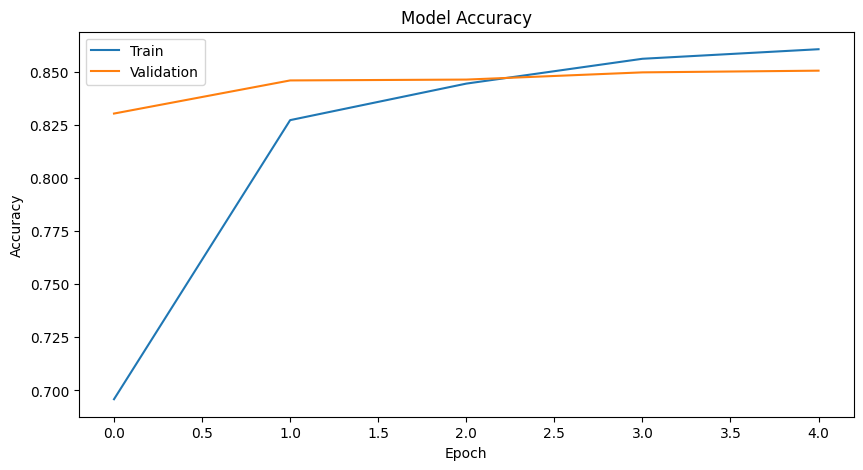

In [127]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

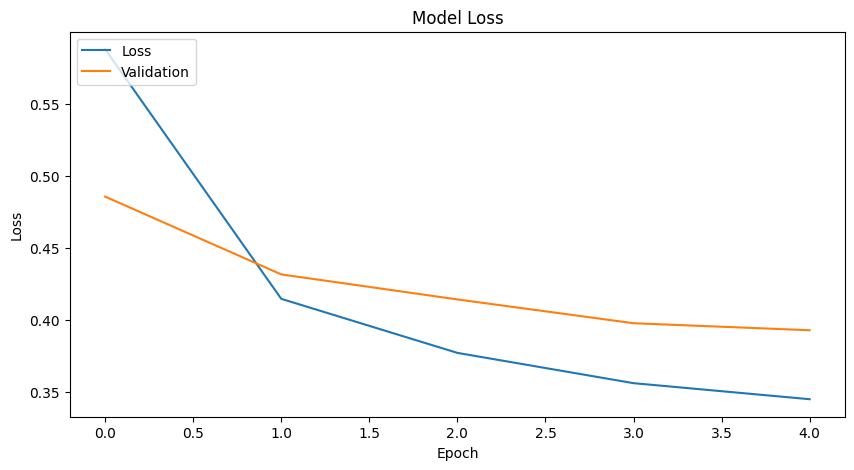

In [129]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

In [128]:
loss, accuracy = model.evaluate(X_test_l, y_test)

print("The accuracy is " + str(accuracy))
print("The loss is " + str(loss))

157/157 [==============================] - 1s 7ms/step - loss: 0.3930 - accuracy: 0.8506
The accuracy is 0.850600004196167
The loss is 0.392986923456192


**Ensembling Method**

Load the Models

In [134]:
# Load the saved BERT model and tokenizer
bert_model_path = "/content/drive/MyDrive/bert_model"
with tf.keras.utils.custom_object_scope({'TFRobertaForSequenceClassification': TFRobertaForSequenceClassification}):
    bert_model = tf.keras.models.load_model(bert_model_path, custom_objects={'hf_compute_loss': tf.keras.losses.BinaryCrossentropy(from_logits=True)})

bert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load the saved BLSTM model
blstm_model_path = "/content/drive/MyDrive/blstm_model"
blstm_model = tf.keras.models.load_model(blstm_model_path)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

**Preprocess Input String**

In [140]:
def preprocess_bert(text, tokenizer, max_length=128):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs['input_ids'], inputs['attention_mask']

def preprocess_blstm(text, vectorizer, max_length=150):
    tokens = vectorizer([text])
    tokens_padded = pad_sequences(tokens, maxlen=max_length)
    return tokens_padded

**Make Predictions**

In [141]:
def predict_bert(text):
    input_ids, attention_mask = preprocess_bert(text, bert_tokenizer)
    outputs = bert_model([input_ids, attention_mask])
    logits = outputs.logits
    probabilities = tf.nn.softmax(logits, axis=-1).numpy()
    return probabilities[0]

def predict_blstm(text):
    tokens_padded = preprocess_blstm(text, vectorizer)
    probabilities = blstm_model.predict(tokens_padded)
    return probabilities[0]

In [142]:
def ensemble_predict(text):
    bert_probs = predict_bert(text)
    blstm_probs = predict_blstm(text)

    # Average the probabilities
    final_probs = (bert_probs + blstm_probs) / 2

    # Get the final prediction
    final_prediction = np.argmax(final_probs)
    return final_prediction, final_probs

In [145]:
text = "The product was bad, but the delivery was fast."

final_prediction, final_probs = ensemble_predict(text)

print(f"Final Prediction: {final_prediction}")
print(f"Prediction Probabilities: {final_probs}")

1/1 [==============================] - 0s 25ms/step
Final Prediction: 0
Prediction Probabilities: [0.67602116 0.23784515]
